In [1]:
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np

import albumentations as A

In [2]:
!wget https://www.apacara.com/media/images/orange.jpg -O image.jpg

--2022-02-04 22:07:04--  https://www.apacara.com/media/images/orange.jpg
Resolving www.apacara.com (www.apacara.com)... 104.21.79.6, 172.67.139.77, 2606:4700:3033::6815:4f06, ...
Connecting to www.apacara.com (www.apacara.com)|104.21.79.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49161 (48K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]  48.01K  --.-KB/s    in 0.001s  

2022-02-04 22:07:04 (89.4 MB/s) - ‘image.jpg’ saved [49161/49161]



In [3]:
def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

In [5]:
image = cv2.imread('image.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

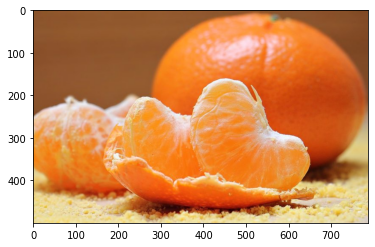

In [6]:
plt.imshow(image)

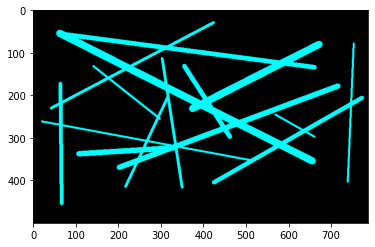

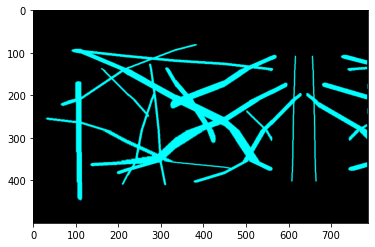

In [10]:
mask = np.zeros(image.shape, np.uint8)
for i in range(random.randint(5, 20)):
  mask = cv2.line(mask, (random.randint(0, image.shape[1]), random.randint(0, image.shape[0])), 
                 (random.randint(0, image.shape[1]), random.randint(0, image.shape[0])), 
                 (1, 255, 255),
                  random.randint(3, 15))
  
plt.imshow(mask.astype(np.uint8))
plt.show()
  
mask = A.GridDistortion(num_steps=7, distort_limit=(-1, 1), p=1)(image=mask)['image']

plt.imshow(mask.astype(np.uint8))
plt.show()

In [13]:
image = apply_mask(image, np.squeeze(mask[:,:,:1], 2), (1, 0.8, 1), alpha=0.95)

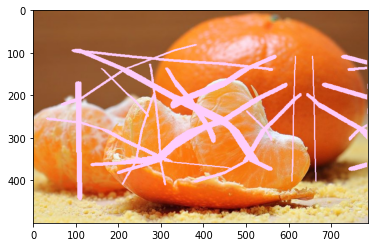

In [14]:
plt.imshow(image)

In [ ]:
!pip install torchmetrics
!pip install segmentation_models_pytorch

     |████████████████████████████████| 396 kB 4.4 MB/s 
     |████████████████████████████████| 88 kB 3.6 MB/s 
     |████████████████████████████████| 376 kB 10.0 MB/s 
     |████████████████████████████████| 58 kB 6.6 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=54d97b1c70874feb7e6b41caa5d9614746bd68baee19ef7d93ac76bcd72b8460
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=2aef54c794be0f66ccfbef7b0d065f04dc7bef6aba7c9154a8c23f5d687d78e3
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
from typing import Any, Callable, Optional, Union

import torch
import torch.nn.functional as F
from torch import nn
from tqdm.auto import tqdm

from torch import Tensor

from torchmetrics.metric import Metric
import segmentation_models_pytorch as smp

__all__ = ["SoftBCEWithLogitsLoss"]


class SoftBCEWithLogitsLoss(nn.Module):
    __constants__ = ["weight", "pos_weight", "reduction", "ignore_index", "smooth_factor"]

    def __init__(
            self,
            weight: Optional[torch.Tensor] = None,
            ignore_index: Optional[int] = -100,
            reduction: str = "mean",
            smooth_factor: Optional[float] = None,
            pos_weight: Optional[torch.Tensor] = None,
    ):
        """Drop-in replacement for torch.nn.BCEWithLogitsLoss with few additions: ignore_index and label_smoothing

        Args:
            ignore_index: Specifies a target value that is ignored and does not contribute to the input gradient.
            smooth_factor: Factor to smooth target (e.g. if smooth_factor=0.1 then [1, 0, 1] -> [0.9, 0.1, 0.9])

        Shape
             - **y_pred** - torch.Tensor of shape NxCxHxW
             - **y_true** - torch.Tensor of shape NxHxW or Nx1xHxW

        Reference
            https://github.com/BloodAxe/pytorch-toolbelt

        """
        super().__init__()
        self.ignore_index = ignore_index
        self.reduction = reduction
        self.smooth_factor = smooth_factor
        self.register_buffer("weight", weight)
        self.register_buffer("pos_weight", pos_weight)

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        """
        Args:
            y_pred: torch.Tensor of shape (N, C, H, W)
            y_true: torch.Tensor of shape (N, H, W)  or (N, 1, H, W)

        Returns:
            loss: torch.Tensor
        """

        if self.smooth_factor is not None:
            soft_targets = (1 - y_true) * self.smooth_factor + y_true * (1 - self.smooth_factor)
        else:
            soft_targets = y_true

        loss = F.binary_cross_entropy_with_logits(
            y_pred, soft_targets, self.weight, pos_weight=self.pos_weight, reduction="none"
        )

        if self.ignore_index is not None:
            not_ignored_mask = y_true != self.ignore_index
            loss *= not_ignored_mask.type_as(loss)

        if self.reduction == "mean":
            loss = loss.mean()

        if self.reduction == "sum":
            loss = loss.sum()

        return loss

class AverageMeter(Metric):
    """Computes the average of a stream of values.

    Forward accepts
        - ``value`` (float tensor): ``(...)``
        - ``weight`` (float tensor): ``(...)``

    Args:
        compute_on_step:
            Forward only calls ``update()`` and returns None if this is
            set to False. default: True
        dist_sync_on_step:
            Synchronize metric state across processes at each ``forward()``
            before returning the value at the step.
        process_group:
            Specify the process group on which synchronization is called.
            default: None (which selects the entire world)
        dist_sync_fn:
            Callback that performs the allgather operation on the metric state.
            When `None`, DDP will be used to perform the allgather.

    Example::
        >>> from torchmetrics import AverageMeter
        >>> avg = AverageMeter()
        >>> avg.update(3)
        >>> avg.update(1)
        >>> avg.compute()
        tensor(2.)

        >>> avg = AverageMeter()
        >>> values = torch.tensor([1., 2., 3.])
        >>> avg(values)
        tensor(2.)

        >>> avg = AverageMeter()
        >>> values = torch.tensor([1., 2.])
        >>> weights = torch.tensor([3., 1.])
        >>> avg(values, weights)
        tensor(1.2500)
    """
    value: Tensor
    weight: Tensor

    def __init__(
        self,
        compute_on_step: bool = True,
        dist_sync_on_step: bool = False,
        process_group: Optional[Any] = None,
        dist_sync_fn: Callable = None,
    ) -> None:
        super().__init__(
            compute_on_step=compute_on_step,
            dist_sync_on_step=dist_sync_on_step,
            process_group=process_group,
            dist_sync_fn=dist_sync_fn,
        )
        self.add_state("value", torch.zeros(()), dist_reduce_fx="sum")
        self.add_state("weight", torch.zeros(()), dist_reduce_fx="sum")

    def update(  # type: ignore
        self, value: "Union[Tensor, float]", weight: "Union[Tensor, float]" = 1.0
    ) -> None:
        """Updates the average with.

        Args:
            value: A tensor of observations (can also be a scalar value)
            weight: The weight of each observation (automatically broadcasted
                to fit ``value``)
        """
        if not isinstance(value, Tensor):
            value = torch.as_tensor(value, dtype=torch.float32, device=self.value.device)
        if not isinstance(weight, Tensor):
            weight = torch.as_tensor(weight, dtype=torch.float32, device=self.weight.device)

        # braodcast_to only supported on PyTorch 1.8+
        if not hasattr(torch, "broadcast_to"):
            if weight.shape == ():
                weight = torch.ones_like(value) * weight
            if weight.shape != value.shape:
                raise ValueError("Broadcasting not supported on PyTorch <1.8")
        else:
            weight = torch.broadcast_to(weight, value.shape)

        self.value += (value * weight).sum()
        self.weight += weight.sum()

    def compute(self) -> Tensor:
        return self.value / self.weight

def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
train_dataloader = # ... создать класс даталоадера(датасета) с аугментацией выше
val_dataloader = # ... создать класс даталоадера(датасета) с аугметацией выше

In [ ]:
img_size = ()
learning_rate = 1e-4

In [ ]:
model = smp.UnetPlusPlus(encoder_name='timm-regnetx_002').cuda()
    
criterion = SoftBCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-5, lr=learning_rate)
scheduler = None # CosineAnnealingWarmUpRestarts(optimizer, T_0=10, T_mult=1, eta_max=0.1,  T_up=10)

scaler = torch.cuda.amp.GradScaler()

losses = AverageMeter().cuda()
metric = AverageMeter().cuda()
best_metric = torch.tensor(-9999)
best_loss = 99999999
n_rounds = 4
k = 0
iters = len(train_dataloader)

In [ ]:
for epoch in range(300):
    losses.reset()
    print('Training...')
    print(('\n' + '%10s' * 5) % ('Epoch', 'gpu_mem', 'cls', 'labels', 'img_size'))
    pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader),
                bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')  # progress bar

    is_early_stopping = False
    model.train()
    for idx, batch in pbar:

        x, y = batch
        x, y = x.cuda() / 255, y.cuda()
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            output = model(x)
        loss = criterion(output, y)
        losses.update(loss)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        if scheduler is not None:
            scheduler.step(epoch + idx / iters)


        mem = f'{torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0:.3g}G'  # (GB)
        pbar.set_description(
            ('%10s' * 2 + '%10.4g' * 3) % (f'{epoch}', mem, losses.compute().cpu().item(),
                                            y.shape[0], img_size[-1]))

    if best_loss > losses.compute().cpu().item():
        best_loss = losses.compute().cpu().item()
        k = 0
    elif k == n_rounds:
        is_early_stopping = True
    else:
        k += 1

    mean_loss = losses.compute().cpu().item()

    print("Training results: \n"
          f"Mean Loss: {mean_loss}"
          )

    metric.reset()
    losses.reset()

    torch.save(model.state_dict(), "weights/last.pt")

    model.eval()
    print(f'\nValidating...')
    print(('\n' + '%10s' * 6) % ('Epoch', 'gpu_mem', 'cls', 'labels', 'img_size', 'metric'))
    pbar = tqdm(val_dataloader, total=len(val_dataloader),
                bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')  # progress bar

    for batch in pbar:
        x, y = batch
        x, y = x.cuda()/255, y.cuda()

        with torch.no_grad():
            output = model(x)
        loss = criterion(output, y)
        losses.update(loss)

        # pred = torch.topk(output, 1)[1].flatten()

        iou = calc_iou(output.detach().cpu().numpy(), y.detach().cpu().numpy())

        metric.update(iou)

        mem = f'{torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0:.3g}G'  # (GB)
        pbar.set_description(('%10s' * 2 + '%10.4g' * 4) % (
            f'{epoch}', mem, losses.compute().cpu().item(), y.shape[0], img_size[-1],
            metric.compute().cpu().item()))

    if metric.compute().cpu().item() > best_metric:
        torch.save(model.state_dict(), "weights/best.pt")
        best_acc = metric.compute().cpu().item()

    mean_loss = losses.compute().cpu().item()
    mean_metric = metric.compute().cpu().item()


    print("Validation results: \n"
          f"Mean Loss: {mean_loss}, Mean Metric: {mean_metric}"
          )

    torch.save(model.state_dict(), "weights/last.pt")